In [1]:
# Estimate CTSM-CAMELS time cost according to DDS runs

In [1]:
import numpy as np
import os, sys, glob, time, re
import netCDF4 as nc
from datetime import datetime
import matplotlib.pyplot as plt

def calculate_creation_time_difference(file_path_1, file_path_2):
    def parse_creation_timestamp(history_str):
        timestamp_str = re.search(r'created on (\d{2}/\d{2}/\d{2} \d{2}:\d{2}:\d{2})', history_str)
        if timestamp_str:
            timestamp_str = timestamp_str.group(1)
            timestamp = datetime.strptime(timestamp_str, '%m/%d/%y %H:%M:%S')
            return timestamp
        else:
            return None

    try:
        with nc.Dataset(file_path_1, 'r') as ncfile1, nc.Dataset(file_path_2, 'r') as ncfile2:
            history_attr_1 = ncfile1.getncattr('history')
            history_attr_2 = ncfile2.getncattr('history')
            
            creation_time_1 = parse_creation_timestamp(history_attr_1)
            creation_time_2 = parse_creation_timestamp(history_attr_2)

            if creation_time_1 and creation_time_2:
                time_difference = creation_time_2 - creation_time_1
                return time_difference
            else:
                return None

    except Exception as e:
        return None

    

In [11]:
inpath = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_Ostrich_m2err/'
basins = np.arange(0, 627)
runs = np.arange(0, 50)

In [12]:
timecost = np.nan * np.zeros([len(basins), len(runs)])
filenum = np.nan * np.zeros([len(basins), len(runs)])

for i in range(len(basins)):
    b = basins[i]
    # print(b)
    for j in range(len(runs)):
        r = runs[j]
        pathbr = f'{inpath}/level1_{b}_OSTRICHcalib/archive/PreserveModelOutput/Run_{r}/'
        files = glob.glob(f'{pathbr}/*clm2.h1.*.nc')
        files.sort()
        if len(files)>2:
            t = calculate_creation_time_difference(files[0], files[-1]).seconds
            timecost[i,j] = t
            filenum[i,j] = len(files) - 1 # t is based on creation time, so the last file should not be counted

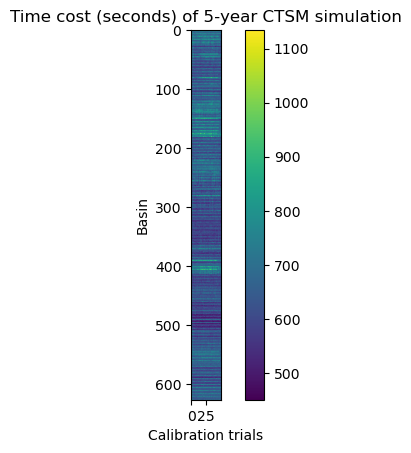

In [13]:
# time map
plt.imshow(timecost)
plt.colorbar()
plt.title('Time cost (seconds) of 5-year CTSM simulation')
plt.ylabel('Basin')
plt.xlabel('Calibration trials')
plt.show()

108.29327485380117


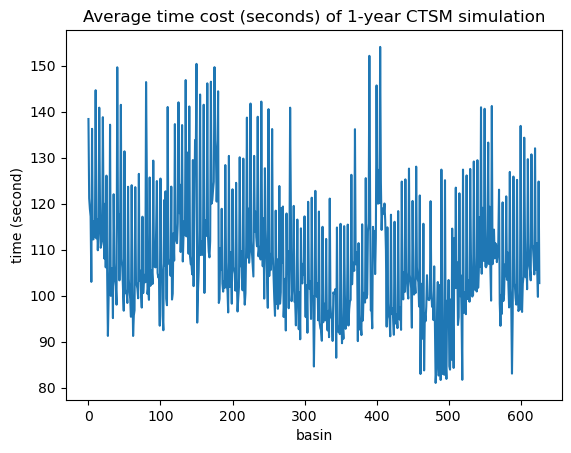

In [16]:
# average time cost / year
timecost_a = timecost / filenum
timecost_a = np.nanmean(timecost_a, axis=1)
print(np.nanmean(timecost_a))
plt.plot(timecost_a)
plt.xlabel('basin')
plt.ylabel('time (second)')
plt.title('Average time cost (seconds) of 1-year CTSM simulation')
plt.show()

In [15]:
# total time cost for 
# 671 basins
# 6-year simulation (1-year spin up and 5-year calibration)
# 60-year spin-up (initial spin up before calibration)
# 35-year after-calib simulation
# 500 trials (MO-ASMO)
# 200 trials (DDS)

tottime1 = np.nanmean(timecost_a) * 671 * (60 + 35 + 6*500) / 3600
print('MO-ASMO calib, 500 trials, time cost (h):', tottime1)

tottime2 = np.nanmean(timecost_a) * 671 * (60 + 35 + 6*200) / 3600
print('DDS calib, 200 trials, time cost (h):', tottime2)

print('Total hours (M):', (tottime1+tottime2)/1e6)

MO-ASMO calib, 500 trials, time cost (h): 62471.53252396036
DDS calib, 200 trials, time cost (h): 26139.138810510074
Total hours (M): 0.08861067133447044
